# Figure 2, Methods

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from lib.models import LIF, LRF

In [2]:
# Set figure aesthetics
sns.set_style("ticks")
sns.set_context("notebook")
qualitative_palette = sns.color_palette(["#009e73","#e59c00", "#55b2e8", "#efe440", "#d65c00", "#0071b2", "#cc78a6", "#000000"])
fs = 13
lfs = 12.5
tfs = 14.5
lw = 2.5

## Event Dependent Scaling Factor

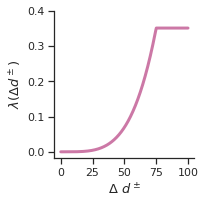

In [3]:
def lmd(delta_t):
    if isinstance(delta_t, (int, float)):
        delta_t = delta_t
    result = np.zeros_like(delta_t)
    for i, delta in enumerate(delta_t):
        result[i] = 1000 * (1. - np.exp(np.log(0.5) * (np.min([delta, 75.]) / 500.)**4.))
    return result

x = np.linspace(0., 100., 1000)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(x, lmd(x), linewidth=lw*1.2, color=qualitative_palette[6])
ax.set_xlabel("$\\Delta\ d^\pm$", fontsize=fs)
ax.set_ylabel("$\lambda(\Delta d^\pm)$", fontsize=fs)
ax.set_xticks([0., 25., 50., 75., 100.])
ax.set_yticks([0., .1, .2, .3, .4])
sns.despine()
fig.tight_layout()

fig.savefig("figure-2-a.svg", pad_inches=0.)

## Surrogate Gradient (SuperSpike)

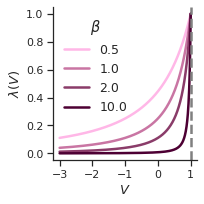

In [4]:
sns.set_palette(sns.color_palette(['#4d0033', '#8a3c69', '#c975a3', '#ffb7e7'][::-1]))

def surrogate(v, beta):
    return 1 / (beta * np.abs(v - 1.) + 1.)**2

x = np.linspace(-3., 1., 1000)

fig, ax = plt.subplots(figsize=(3, 3))
for i, beta in enumerate([0.5, 1., 2., 10.]):
    ax.plot(x, surrogate(x, beta), label=beta, linewidth=lw)
ax.legend(title="$\\beta$", framealpha=0., edgecolor="w", shadow=False, fontsize=lfs, title_fontsize=tfs)
ax.set_xlabel("$V$", fontsize=fs)
ax.set_ylabel("$\lambda(V)$", fontsize=fs)
ax.axvline(1., color="grey", linestyle="--", linewidth=lw)
ax.set_xticks([-3, -2, -1, 0, 1])
sns.despine()
fig.tight_layout()

fig.savefig("figure-2-b.svg", pad_inches=0.)

## LIF Dynamics

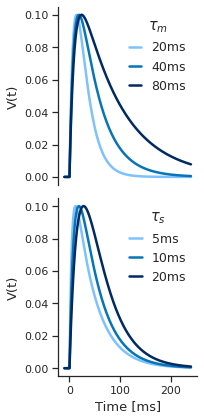

In [5]:
length = 250
xs = np.zeros(length)
xs[10] = 1.

# Vary tau m
tau_ms = [20., 40., 80.]
tau_s = 10.

vss1 = []
for i, tau_m in enumerate(tau_ms):
    vs = []
    
    x_hat = np.log(tau_s / tau_m) * (tau_s * tau_m) / (tau_s - tau_m)
    kappa = 1. / (np.exp(-x_hat / tau_m) - np.exp(-x_hat / tau_s))
    
    weights = np.asarray([0.1]) * kappa
    
    lif = LIF(0., 0., weights, tau_s, tau_m)
    
    for t, x in enumerate(xs):
        v, spiked = lif(np.asarray([x]))
        vs.append(v)
    
    vss1.append(vs)

# Vary tau s
tau_m = 40.
tau_ss = [5., 10., 20.]

vss2 = []
for i, tau_s in enumerate(tau_ss):
    x_hat = np.log(tau_s / tau_m) * (tau_s * tau_m) / (tau_s - tau_m)
    kappa = 1. / (np.exp(-x_hat / tau_m) - np.exp(-x_hat / tau_s))
    
    weights = np.asarray([0.1]) * kappa
    
    lif = LIF(0., 0., weights, tau_s, tau_m)
    
    vs = []
    for t, x in enumerate(xs):
        v, spiked = lif(np.asarray([x]))
        vs.append(v)
    
    vss2.append(vs)

# Plot
sns.set_palette(sns.color_palette(['#002a61', '#0675b6', '#7dc2ff'][::-1]))

x = np.linspace(-10., 240., length)

fig, axs = plt.subplots(2, 1, figsize=(3, 6), sharey=True)
for i, vs in enumerate(vss1):
    axs[0].plot(x, vs, linewidth=lw, label=f"{int(tau_ms[i])}ms")

axs[0].set_xticks([])
axs[0].set_ylabel("V(t)", fontsize=fs)
axs[0].legend(title="$\\tau_m$", handlelength=1.,shadow=False, edgecolor="w", fontsize=lfs, title_fontsize=tfs)
sns.despine(ax=axs[0], bottom=True)

for i, vs in enumerate(vss2):
    axs[1].plot(x, vs, linewidth=lw, label=f"{int(tau_ss[i])}ms")

axs[1].set_ylabel("V(t)", fontsize=fs)
axs[1].set_xlabel("Time [ms]", fontsize=fs)
axs[1].legend(title="$\\tau_s$", handlelength=1., shadow=False, edgecolor="w", fontsize=lfs, title_fontsize=tfs)
sns.despine(ax=axs[1])
fig.tight_layout()

fig.savefig("figure-2-c.svg", pad_inches=0.)

## LRF Phase Plane

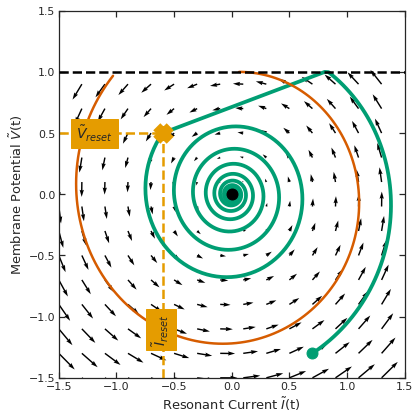

In [6]:
# Aesthetics
sns.set_style("ticks", {"ytick.left": True,
                        "ytick.right": True,
                        "xtick.bottom": True,
                        "xtick.top": True,
                        "ytick.direction": "in",
                        "xtick.direction": "in"})

colors = [qualitative_palette[0], qualitative_palette[4], qualitative_palette[1]]

# Parameters
b = -20.
omega = 50. * np.pi * 2.

# Dynamics
lrf = LRF(0.7-1.3j, -0.6+0.5j, [0+0j], b, omega, 0.1)
separatrix = lrf.separatrix()
trajectory = lrf.generate(np.zeros((1, 8000)))[0]

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(trajectory.real, trajectory.imag, color=colors[0], linewidth=lw*1.5)
ax.plot(separatrix.real, separatrix.imag, color=colors[1], linewidth=lw)
ax.axhline(1., linestyle="--", color="k", linewidth=lw, zorder=4)
ax.scatter(0.7, -1.3, color=[colors[0]], s=120)
ax.scatter(0., 0., c="k", s=120, zorder=4)

# Reset
ax.scatter(-0.6, 0.5, marker="x", c=[colors[2]], s=180, zorder=4, linewidth=lw*4)
ax.hlines(0.5, -1.5, -0.6, color=colors[2], linewidth=lw, linestyle="--")
ax.vlines(-0.6, -1.5, 0.5, color=colors[2], linewidth=lw, linestyle="--")

# Quiver
X, Y = np.meshgrid(np.arange(-1.5, 1.5, 0.2), np.arange(-1.7, 1., 0.2))
real = b * X - omega * Y
imag = b * Y + omega * X

ax.quiver(X, Y, real, imag)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

ax.text(-.7, -1.2, "$\\tilde{I}_{reset}$", backgroundcolor=colors[2], fontsize=14, rotation="vertical")
ax.text(-1.35, 0.45, "$\\tilde{V}_{reset}$", backgroundcolor=colors[2], fontsize=14, rotation="horizontal")

ax.set_xlabel("Resonant Current $\\tilde{I}$(t)", fontsize=fs)
ax.set_ylabel("Membrane Potential $\\tilde{V}$(t)", fontsize=fs)

fig.tight_layout()

fig.savefig("figure-2-d.svg", pad_inches=0.)

## LRF Dynamics

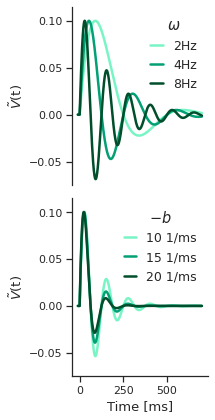

In [7]:
length = 710
xs = np.zeros(length)
xs[10] = 1.

# Vary omegas
omegas = [2., 4., 8.]
b = -6. 

vss1 = []
for i, omega in enumerate(omegas):
    vs = []
    
    omega_ = (omega * 2. * np.pi) / 1000.
    b_ = b / 1000.
    x_hat = -np.arctan(omega_ / b_) / omega_
    kappa = 1. / (np.exp(x_hat * b_) * np.sin(x_hat * omega_))
    
    weights = np.asarray([0.1]) * kappa
    
    lrf = LRF(0+0j, 0+0j, weights, b, omega * 2. * np.pi)
    
    for t, x in enumerate(xs):
        v, spiked = lrf(np.asarray([x]))
        vs.append(v.imag)
    
    vss1.append(vs)
    
# Vary bs
omega = 8.
bs = [-10., -15., -20.]

vss2 = []
for i, b in enumerate(bs):
    vs = []
    
    omega_ = (omega * 2. * np.pi) / 1000.
    b_ = b / 1000.
    x_hat = -np.arctan(omega_ / b_) / omega_
    kappa = 1. / (np.exp(x_hat * b_) * np.sin(x_hat * omega_))
    
    weights = np.asarray([0.1]) * kappa
    
    lrf = LRF(0+0j, 0+0j, weights, b, omega * 2. * np.pi)
    
    for t, x in enumerate(xs):
        v, spiked = lrf(np.asarray([x]))
        vs.append(v.imag)
    
    vss2.append(vs)

# Plot
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette(['#004e2b', '#03a075', '#79f5c5'][::-1])

x = np.linspace(-10., 699., length)

fig, axs = plt.subplots(2, 1, figsize=(3.15, 6), sharey=True)
for i, vs in enumerate(vss1):
    axs[0].plot(x, vs, linewidth=lw, label=f"{int(omegas[i])}Hz")

axs[0].set_xticks([])
axs[0].set_ylabel("$\\tilde{V}$(t)", fontsize=fs)
axs[0].legend(title="$\omega$", handlelength=1., shadow=False, edgecolor="w", fontsize=lfs, title_fontsize=tfs)
sns.despine(ax=axs[0], bottom=True)

for i, vs in enumerate(vss2):
    axs[1].plot(x, vs, linewidth=lw, label=f"{int(-1.*bs[i])} 1/ms")

axs[1].set_ylabel("$\\tilde{V}$(t)", fontsize=fs)
axs[1].set_xlabel("Time [ms]", fontsize=fs)
axs[1].legend(title="$-b$", handlelength=1., shadow=False, edgecolor="w", fontsize=lfs, title_fontsize=tfs)
axs[1].set_xticks([0, 250, 500])
axs[1].set_yticks([0.1, 0.05, 0., -0.05, -0.1])
axs[1].set_ylim([-0.075, 0.115])
sns.despine(ax=axs[1])
fig.tight_layout()

fig.savefig("figure-2-e.svg", pad_inches=0.)

## Weight Distribution

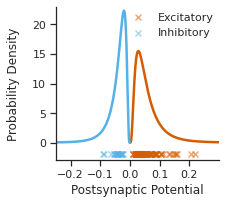

In [8]:
np.random.seed(1)

# Parameters
excitatory_n = 80
inhibitory_n = 20

beta_plus = 1.2

tau_m = 20.
tau_s = 5.

# Lognormalormal distribution
mean_psp = 1. / 20.
variance_psp = (1 / 25)**2

mean_corrected = np.log(mean_psp**2 / np.sqrt(mean_psp**2 + variance_psp))
var_corrected = np.log(1 + variance_psp / mean_psp**2)

# Sample weights
w_exc = np.random.lognormal(mean_corrected, np.sqrt(var_corrected), excitatory_n) * beta_plus
w_inh = -np.random.lognormal(mean_corrected, np.sqrt(var_corrected), inhibitory_n)

# Plot
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette(qualitative_palette)
colors = sns.color_palette()

x = np.linspace(0.0001, 0.4, 10000)

fig, ax = plt.subplots(figsize=(3.3, 3))
ax.scatter(w_exc, np.ones(excitatory_n)*-2., c=[colors[4]], label="Excitatory", alpha=0.5, marker="x")
ax.scatter(w_inh, np.ones(inhibitory_n)*-2., c=[colors[2]], label="Inhibitory", alpha=0.5, marker="x")
ax.plot(x, stats.lognorm.pdf(x, s=np.sqrt(var_corrected), scale=np.exp(mean_corrected)*beta_plus), color=colors[4], linewidth=lw)
ax.plot(-x, stats.lognorm.pdf(x, s=np.sqrt(var_corrected), scale=np.exp(mean_corrected)/beta_plus), color=colors[2], linewidth=lw)

ax.set_ylim([-3, 23])
ax.set_xlim([-0.25, 0.3])

ax.set_xticks([-0.2, -0.1, 0., 0.1, 0.2])
ax.set_xlabel("Postsynaptic Potential")
ax.set_ylabel("Probability Density", labelpad=12)
ax.legend(frameon=False, borderpad=0)
sns.despine()
fig.tight_layout()

fig.savefig("figure-2-f.svg", pad_inches=0.)

## Normalisation factor kappa

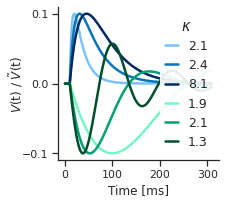

In [9]:
length = 310
xs = np.zeros(length)
xs[10] = 1.
vss = []
kappas = []

# LRF
tau_ss = [5., 12., 30.]
tau_ms = [20., 40., 42.]

for tau_s, tau_m in zip(tau_ss, tau_ms):
    x_hat = np.log(tau_s / tau_m) * (tau_s * tau_m) / (tau_s - tau_m)
    kappa = 1. / (np.exp(-x_hat / tau_m) - np.exp(-x_hat / tau_s))

    weights = np.asarray([0.1]) * kappa
    kappas.append(kappa)

    lif = LIF(0., -1., weights, tau_s, tau_m)
    
    vs = []
    for t, x in enumerate(xs):
        v, spiked = lif(np.asarray([x]))
        vs.append(v)
    vss.append(vs)


# LIF
omegas = [2., 4., 8.]
bs = [-6. , -14., -9.]

for b, omega in zip(bs, omegas):    
    omega_ = (omega * 2. * np.pi) / 1000.
    b_ = b / 1000.
    x_hat = -np.arctan(omega_ / b_) / omega_
    kappa = 1. / (np.exp(x_hat * b_) * np.sin(x_hat * omega_))
    kappas.append(kappa)
    
    weights = np.asarray([-0.1]) * kappa
    
    lrf = LRF(0+0j, 0+0j, weights, b, omega * 2. * np.pi)
    
    vs = []
    for t, x in enumerate(xs):
        v, spiked = lrf(np.asarray([x]))
        vs.append(v.imag)
    
    vss.append(vs)


# Plot
fig, ax = plt.subplots(figsize=(3.3, 3))
colors = sns.color_palette(sns.color_palette(['#002a61', '#0675b6', '#7dc2ff'][::-1]))
for i in range(3):
    ax.plot(vss[i], label=f"{np.round(kappas[i], 1)}", color=colors[i], linewidth=lw)

colors = sns.color_palette(['#004e2b', '#03a075', '#79f5c5'][::-1])
for i in range(3):
    ax.plot(vss[3+i], label=str(np.round(kappas[3+i], 1)), color=colors[i], linewidth=lw)

ax.set_yticks([-0.1, 0., 0.1])
ax.set_xlabel("Time [ms]")
ax.set_ylabel("$V$(t) / $\\tilde{V}$(t)", labelpad=-3)
ax.legend(title="$\\kappa$", title_fontsize=tfs, loc="center right", handlelength=1., shadow=False, edgecolor="w", framealpha=.9, fontsize=lfs)
sns.despine()
fig.tight_layout()

fig.savefig("figure-2-g.svg", pad_inches=0.)